In [8]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

from IPython import display

%matplotlib inline

pos = {}
with open('berlin52.tsp') as f:
    for i, line in enumerate(f):
        x, y = line.split()
        pos[i] = np.array([x, y], dtype=np.float64)
        #i == 9

data = np.zeros((len(pos), len(pos)))
for i in pos.keys():
    for j in pos.keys():
        data[i, j] = np.sqrt(np.sum((pos[j] - pos[i])**2))
n = len(pos)

In [6]:
np.savetxt('data.txt', data)

In [11]:
def evaluate_cost(route):
    return np.sum(data[route[:-1], route[1:]])

def find_nearest_node(nodes, n):
    return nodes[np.argmin(data[nodes, n])]

def construct_cheapest_insertion(start_point, alpha, plot_graph = False, delay = 0.0, node_size = 5):
    second_point = np.argmin(data[start_point,:]) # Inserir o segumento elemento que possua a menor distancia do primeiro
    solution = [start_point, second_point]

    if plot_graph:
        G = nx.Graph()
        G.add_nodes_from(pos.keys())
        G.add_edge(start_point, second_point)
        plt.figure(figsize=(15,15))
        plt.clf()
        nx.draw(G, pos, node_size=node_size)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(delay)

    remain_vertices = [k for k in range(n) if k not in solution]
    while remain_vertices:
        cost_array = []
        I = []
        Index = []
        for index, x in enumerate(remain_vertices):
            i = find_nearest_node(solution, x)
            j = solution[(solution.index(i) + 1) % len(solution)]
            cost_array.append(data[i,x] + data[x,j] - data[i,j])
            I.append(i)
            Index.append(index)
        gmax, gmin = np.max(cost_array), np.min(cost_array)
        LRC = np.where(cost_array <= gmin + alpha*(gmax - gmin), 1, 0)
        index = np.random.choice(np.array(Index)[np.nonzero(LRC)])
        k = remain_vertices[index]
        i = I[index]
        j = solution[(solution.index(i) + 1) % len(solution)]
        
        if plot_graph:
            G.add_edge(i, k)
            G.add_edge(k, j)
            if len(solution) > 3: G.remove_edge(j, i)
            plt.clf()
            nx.draw(G, pos, node_size=node_size)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(delay)
        
        solution.insert((solution.index(i) + 1) % len(solution), k)
        remain_vertices.remove(k)
    return solution

def improve_2opt(initial_route):
    solution = None
    best_cost = evaluate_cost(initial_route)
    neighbor_solution = initial_route.copy()
    n = len(initial_route)
    for i in range(n):
        for j in range(i+1, n):
            neighbor_solution = neighbor_solution[:i] + list(reversed(neighbor_solution[i+1:j])) + neighbor_solution[j+1:]
            neighbor_cost = evaluate_cost(neighbor_solution)
            if neighbor_cost < best_cost:
                solution = neighbor_solution
                best_cost = neighbor_cost
    return solution

def search_neighborhood(initial_route):
    solution = None
    best_cost = evaluate_cost(initial_route)
    for i in range(n-1):
        neighbor_solution = initial_route.copy()
        neighbor_solution[i], neighbor_solution[i+1] = neighbor_solution[i+1], neighbor_solution[i]
        if i == 0:
            neighbor_solution[-1] = neighbor_solution[0]
        if i == len(neighbor_solution) - 1:
            neighbor_solution[0] = neighbor_solution[-1]
        cost = evaluate_cost(neighbor_solution)
        if cost < best_cost:
            best_cost = cost
            solution = neighbor_solution
            break
    return solution, best_cost

def evaluate_grasp(start_point, alpha, plot_graph = False, delay = 0.0, node_size = 5):
    cost_array = []
    optimal_cost = np.inf
    solution = construct_cheapest_insertion(start_point, alpha)
    while True:
        optimal_solution, optimal_cost = search_neighborhood(solution)
        cost_array.append(optimal_cost)

        if optimal_solution: solution = optimal_solution
        else: break
        
        if plot_graph:
            G = nx.Graph()
            nx.add_path(G, optimal_solution + [optimal_solution[0]])
            plt.figure(figsize=(15, 15))
            plt.clf()
            nx.draw(G, pos, node_size=node_size)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(delay)
    return solution, cost_array

In [17]:
np.random.seed(5)
solution, cost_array = evaluate_grasp(start_point = 0, alpha = 0.05, plot_graph = False, delay = 0.0)

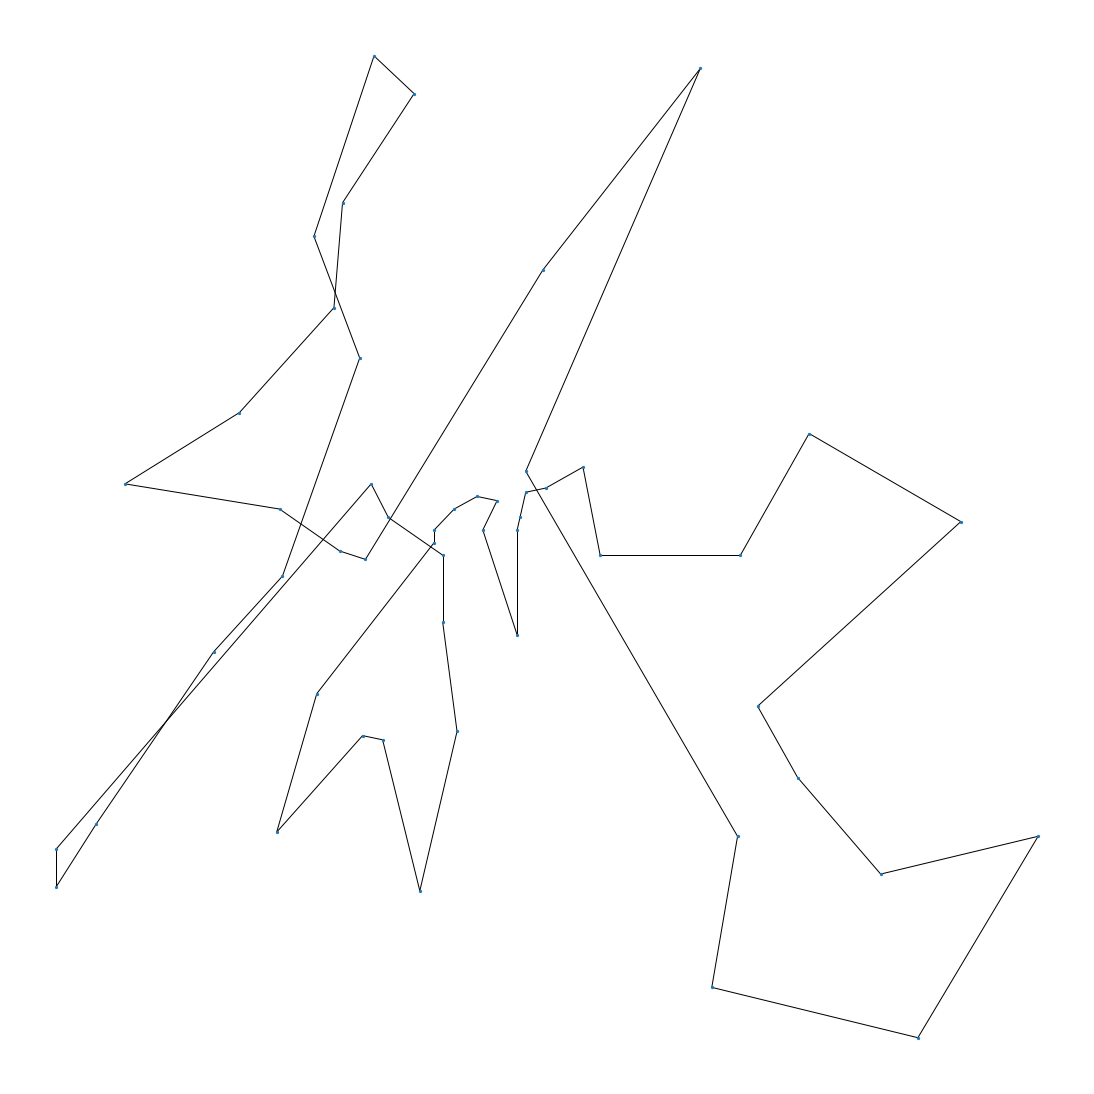

In [18]:
#solution = np.array([37, 42, 32, 5, 24, 11, 25, 46, 13, 51, 12, 26, 27, 10, 50, 3, 14, 47, 23, 4, 45, 43, 15, 49, 28, 29, 41, 1, 6, 20, 22, 19, 31, 21, 30, 17, 16, 2, 18, 9, 8, 7, 40, 44, 0, 35, 34, 33, 39, 38, 48, 36, 37])
G = nx.Graph()
nx.add_path(G, solution)
plt.figure(figsize=(15,15))
plt.clf()
nx.draw(G, pos, node_size=5)

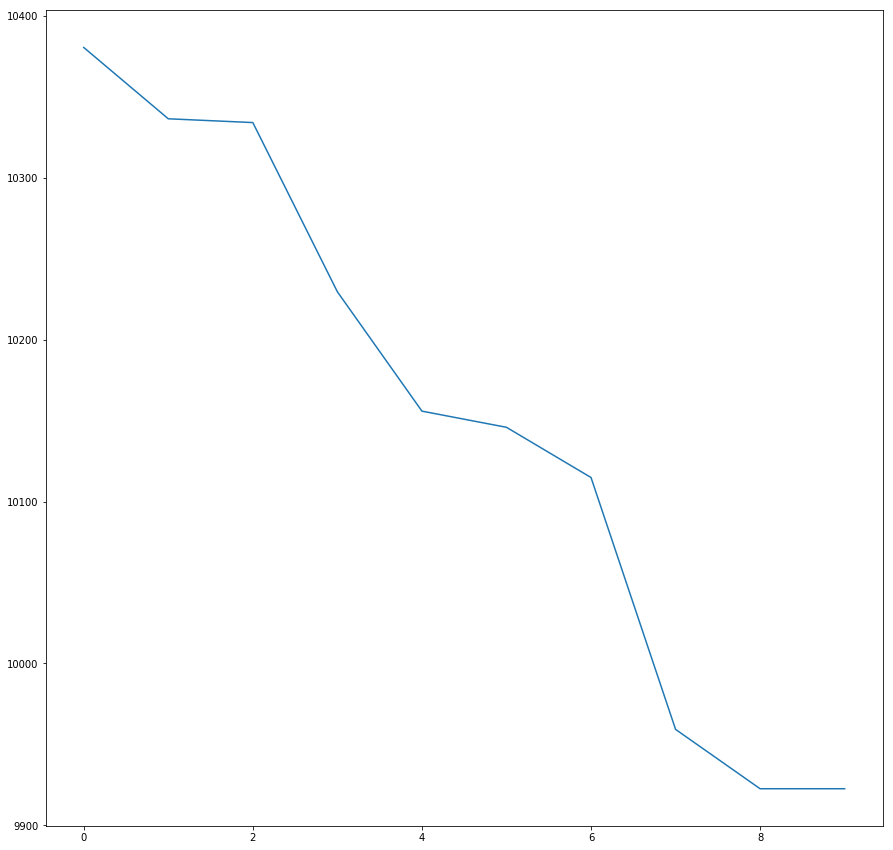

In [16]:
plt.figure(figsize=(15,15))
plt.plot(cost_array)